# Exploring film dialogue

There are two parts to this notebook. The first part is just general practice in Pandas. We won't work through all of that in class. But if Pandas is unfamiliar, you may want to work through those sections on your own.

The second part develops models of film dialogue. We will

1. look for words overrepresented in the dialogue of men and women
2. ask whether gender norms are stronger in particular genres, and
3. ask whether gender norms weaken over time


## A. Loading the film dialogue dataset; reviewing Pandas

To start with we'll import useful modules.

In [1]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
import random
from pathlib import Path

#### read in the dialogue dataset

It has one line for each character; the field ```lines``` contains all dialogue attributed to that character in the [Cornell Movie Dialogs Corpus](https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html). Separate lines are delimited by slashes, but we'll ignore that here.

We call the dataset ```chars``` because the it has one line per character.

In [2]:
dialogpath = Path('../../data/movie_dialogue.tsv')

chars = pd.read_csv(dialogpath, sep = '\t')

# let's also randomize the row order
chars = chars.sample(frac = 1)

In [3]:
chars.head()

,mid,cid,cname,mname,gender,wordcount,year,genres,comedy,thriller,drama,romance,lines
1887,m444,u6646,COSMO,moonstruck,m,396,1987,"['comedy', 'romance', 'drama']",True,False,True,True,A man... under stands one day... that his life...
1222,m319,u4791,HANOVER,deep rising,m,262,1998,"['action', 'horror', 'sci-fi', 'thriller']",False,True,False,False,Maybe we lost them. / You trying to take over ...
2451,m552,u8131,ELAINE,the limey,f,1152,1999,"['crime', 'drama', 'mystery', 'thriller']",False,True,True,False,I'd rather be with him than without him. I don...
2950,m95,u1422,EMMA,i am legend,f,248,2007,"['drama', 'sci-fi', 'thriller']",False,True,True,False,You have to go. He'll never stop. Leave this ...
2749,m610,u8960,TIN MAN,the wizard of oz,m,668,1939,"['adventure', 'family', 'fantasy', 'musical']",False,False,False,False,Now I know I've got a heart -- 'cause it's bre...


#### reviewing pandas: ways to explore the data

Once we've loaded this dataframe, you can explore it in all the ways Melanie Walsh recommends in ["Pandas Basics — Part 2."](https://melaniewalsh.github.io/Intro-Cultural-Analytics/Data-Analysis/Pandas-Basics-Part2.html) For instance, what are the data types of the columns?

In [4]:
chars.dtypes

mid          object
cid          object
cname        object
mname        object
gender       object
wordcount     int64
year          int64
genres       object
comedy         bool
thriller       bool
drama          bool
romance        bool
lines        object
dtype: object

You can also use the ```.describe()``` function, check for missing data with ```.isna()```, rename a column or drop a column, and sort the whole dataframe, by say wordcount or release year. Note that when we run the sort below, we get a sorted dataframe as *output* of the statement. But it doesn't actually change the order of rows in ```chars``` unless we start the command with ```chars =``` or include an argument ```inplace = True``` inside the parentheses.

In [5]:
chars.sort_values(by='wordcount', ascending=False)

,mid,cid,cname,mname,gender,wordcount,year,genres,comedy,thriller,drama,romance,lines
292,m150,u2340,NIXON,nixon,m,7798,1995,"['biography', 'drama']",False,False,True,False,"For Christ's sake, it soils my mother's memory..."
1047,m289,u4331,ACE,casino,m,6387,1995,"['biography', 'crime', 'drama']",False,False,True,False,"Now, instead of the cops only lookin' at Nicky..."
809,m243,u3681,ALVY,annie hall,m,5853,1977,"['comedy', 'drama', 'romance']",True,False,True,True,Your girl friend's name is Ralph? / You don't ...
41,m104,u1568,JIM,jfk,m,5511,1991,"['biography', 'drama', 'history', 'mystery', '...",False,True,True,False,"Gentlemen, I will not hear this. I value Bill..."
361,m161,u2495,STEW,platinum blonde,m,4905,1931,"['comedy', 'romance']",True,False,False,True,"All right, I'm a child. Have it any way you wa..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
691,m221,u3335,HARRY,total recall,m,103,1990,"['action', 'adventure', 'sci-fi', 'thriller']",False,True,False,False,"Unh-uh, pal. You've got yourself mixed up wit..."
2551,m571,u8418,SRT,thx 1138,m,102,1971,"['drama', 'mystery', 'sci-fi', 'thriller']",False,True,True,False,Just look at all those people. / Save yourself...
1824,m431,u6496,SPRINGFIELD,manhunter,m,102,1986,"['crime', 'thriller']",False,True,False,False,No. / It's at the vet's. The kids brought it i...
1292,m331,u4986,SHERRY,election,f,101,1999,"['comedy', 'drama']",True,False,True,False,I was lonely. You took advantage / We made a ...


#### reviewing more powers of Pandas: indexing and selecting data

The functions explored here are related to Melanie Walsh's post on [Pandas — Part 3.](https://melaniewalsh.github.io/Intro-Cultural-Analytics/Data-Analysis/Pandas-Basics-Part3.html)

How many different movies do we have in this data? We have one row for each character--so 2969 characters--but how many *movies*? The ```unique``` method is useful here. (You could also transform the column into a set and take the length of the set.)

In [6]:
len(chars['mname'].unique())

600

Notice that in order to focus on a single column, I selected by using square brackets and a string that was the column name. There are several other ways to select parts of a dataframe. We can use ```.iloc[]``` to select rows in integer order. *Notice the square brackets; this is a form of indexing/selection, not a function call, which is done with round parentheses.*

In [7]:
chars.iloc[292, ]

mid                                                       m527
cid                                                      u7801
cname                                                      SID
mname                                                 spare me
gender                                                       m
wordcount                                                  576
year                                                      1992
genres                                            ['thriller']
comedy                                                   False
thriller                                                  True
drama                                                    False
romance                                                  False
lines        See ya 'round Faz. / The Faz sure took care a ...
Name: 2307, dtype: object

We can also set a column as an "index," and then select rows based on the index. Right now that's hard to demonstrate, because there is no index on this dataframe other than the integer sequence of rows. So ```.loc[]``` will behave just like ```.iloc[]``` (Test it if you don't believe me.) But we can also set another column as the index. For instance, character id.

In [8]:
chars = chars.set_index('cid')
chars.head()

,mid,cname,mname,gender,wordcount,year,genres,comedy,thriller,drama,romance,lines
cid,,,,,,,,,,,,
u6646,m444,COSMO,moonstruck,m,396,1987,"['comedy', 'romance', 'drama']",True,False,True,True,A man... under stands one day... that his life...
u4791,m319,HANOVER,deep rising,m,262,1998,"['action', 'horror', 'sci-fi', 'thriller']",False,True,False,False,Maybe we lost them. / You trying to take over ...
u8131,m552,ELAINE,the limey,f,1152,1999,"['crime', 'drama', 'mystery', 'thriller']",False,True,True,False,I'd rather be with him than without him. I don...
u1422,m95,EMMA,i am legend,f,248,2007,"['drama', 'sci-fi', 'thriller']",False,True,True,False,You have to go. He'll never stop. Leave this ...
u8960,m610,TIN MAN,the wizard of oz,m,668,1939,"['adventure', 'family', 'fantasy', 'musical']",False,False,False,False,Now I know I've got a heart -- 'cause it's bre...


Now notice what happens when we pass a list of character ids

In [9]:
chars.loc[['u3681', 'u8858']]

,mid,cname,mname,gender,wordcount,year,genres,comedy,thriller,drama,romance,lines
cid,,,,,,,,,,,,
u3681,m243,ALVY,annie hall,m,5853,1977,"['comedy', 'drama', 'romance']",True,False,True,True,Your girl friend's name is Ralph? / You don't ...
u8858,m601,CAITLIN,what lies beneath,f,100,2000,"['drama', 'horror', 'mystery', 'thriller']",False,True,True,False,Someone crying. A girl. I thought I was craz...


We can also select rows using a Boolean mask. For instance, suppose we create a list of length equal to the dataframe length, with all members of the list ```False```, except for two ```Trues.```

In [10]:
mask = [False] * chars.shape[0]   # If it's not clear what this does, create a cell, and
mask[130] = True                  # execute chars.shape. Then another cell, and 
mask[1030] = True                 # execute [True] * 4
print('The length is ', len(mask))
print('and the number of Trues is ', sum(mask))

The length is  2969
and the number of Trues is  2


In [11]:
chars[mask]

,mid,cname,mname,gender,wordcount,year,genres,comedy,thriller,drama,romance,lines
cid,,,,,,,,,,,,
u6567,m436,NATALIE,memento,f,799,2000,"['crime', 'drama', 'mystery', 'thriller']",False,True,True,False,"I've got to get back for the evening shift, so..."
u3944,m262,BRUCE,batman,m,648,1989,"['crime', 'drama', 'thriller', 'action', 'adve...",False,True,True,False,If not for you I never would've made it. You k...


In this example, the Boolean mask is just a silly way of doing the same thing as ```chars.iloc[[130, 1030]]```. But there are also ways to use the mask where it becomes genuinely useful.

In [12]:
chars[chars['mname'] == 'what lies beneath']

,mid,cname,mname,gender,wordcount,year,genres,comedy,thriller,drama,romance,lines
cid,,,,,,,,,,,,
u8864,m601,MRS. FEUR,what lies beneath,f,240,2000,"['drama', 'horror', 'mystery', 'thriller']",False,True,True,False,I'm sorry that I frightened you like that. Bu...
u8859,m601,CLAIRE,what lies beneath,f,1965,2000,"['drama', 'horror', 'mystery', 'thriller']",False,True,True,False,Then we both are. / What? / Did you? / I start...
u8862,m601,JODY,what lies beneath,f,630,2000,"['drama', 'horror', 'mystery', 'thriller']",False,True,True,False,"Trust me, Claire. You hear something... chang..."
u8867,m601,NORMAN,what lies beneath,m,1169,2000,"['drama', 'horror', 'mystery', 'thriller']",False,True,True,False,What? / Shhhh. / IT'S TRUE. That's...you have...
u8860,m601,DR. DRAYTON,what lies beneath,m,141,2000,"['drama', 'horror', 'mystery', 'thriller']",False,True,True,False,That can't feel good. / What? / You were in an...
u8858,m601,CAITLIN,what lies beneath,f,100,2000,"['drama', 'horror', 'mystery', 'thriller']",False,True,True,False,Someone crying. A girl. I thought I was craz...


The comparison operator ```==``` will test every member of the column ```mname``` and return True in cases where the expressions is true. Note that comparisons only *broadcast* across lists this way if you're working with pandas columns and numpy arrays. Broadcasting doesn't work with basic Python lists; it will always return False, because a list is not *the same thing as* a single element.

In [13]:
fruit_list = ['apple', 'orange', 'apple']
fruit_list == 'apple'

False

In [14]:
fruit_series = pd.Series(['apple', 'orange', 'apple'])
fruit_series == 'apple'

0     True
1    False
2     True
dtype: bool

The columns in a pandas DataFrame are each a pandas Series; that's why you can use comparisons to create Boolean masks.

#### Exercise for you to try at home

Create a list of all the movie titles that are comedies. The list should only include *unique* values; we don't need six copies of 'airplane!'

In [15]:
chars.loc[chars['comedy'] == True, 'mname'].unique()

array(['moonstruck', 'happy birthday, wanda june', 'get shorty',
       'hannah and her sisters', 'game 6', 'even cowgirls get the blues',
       'nurse betty', 'harold and maude', 'jerry maguire',
       'sugar & spice', 'high fidelity', 'dark star',
       'dr. strangelove or: how i learned to stop worrying and love the bomb',
       'only you', 'ghost world', 'trouble in paradise', 'notting hill',
       'sleepless in seattle', 'wonder boys', 'the apartment',
       'the sting', 'erik the viking', 'birthday girl',
       'who framed roger rabbit', 'the lost boys', 'pretty woman',
       'smoke', 'south park: bigger longer & uncut',
       'intolerable cruelty', 'crime spree', 'rush hour', 'ninotchka',
       'the rocky horror picture show', 'shock treatment', 'out of sight',
       'meet john doe', 'toy story', 'chill factor', 'fletch',
       'buffy the vampire slayer', 'beavis and butt-head do america',
       'annie hall', 'punch-drunk love', 'blast from the past',
       "a hard

## B. Now let's create some models of film dialogue!

Because we've explored Naive Bayes models, I'm going to use that function in the examples that follow. But if you're disappointed with the accuracy we're getting, rest assured that it's possible to do better once we learn fancier algorithms.

We're going to be using raw word frequencies as predictive features.

So first we need to create a dataframe that stores the wordcounts for each character.

In [16]:
if 'cid' in chars.columns:         
    character_ids = chars['cid']
    chars = chars.set_index('cid')   # If we haven't made this the index yet, let's do it.
else:
    character_ids = chars.index.tolist()

vectorizer = CountVectorizer(max_features = 8000)
sparse_counts = vectorizer.fit_transform(chars['lines']) # the vectorizer produces something
                                                               # called a 'sparse matrix'; we need to
                                                               # unpack it
wordcounts = pd.DataFrame(sparse_counts.toarray(), index = character_ids, 
                            columns = vectorizer.get_feature_names())
wordcounts.head()

,00,000,10,100,1000,11,12,13,14,15,...,yuh,yup,yuppie,zack,zero,zip,zoe,zone,zoo,zuzu
u6646,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
u4791,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
u8131,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
u1422,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
u8960,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Modeling comedic characters

Let's start by building a model that distinguishes characters in comedies from other characters.

Since we've got lots of variables, a regular linear model would overfit the data. So we'll need to distinguish our test set from a training set. Let's choose 600 random rows as a test set. The .sample() function will do this.

In [17]:
test_X = wordcounts.sample(600)
test_X.head(2)

,00,000,10,100,1000,11,12,13,14,15,...,yuh,yup,yuppie,zack,zero,zip,zoe,zone,zoo,zuzu
u4385,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
u6039,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Notice that we have the character ids as index. That means we can select the 'comedy' columns for the same rows and make those test_y. 

In [18]:
test_characters = test_X.index.tolist()
test_y = chars.loc[test_characters, 'comedy']

print('The length of your test set is ', len(test_y))
print('And of that group', sum(test_y), 'are from a comedy.')

The length of your test set is  600
And of that group 172 are from a comedy.


Note that right now we have these vales as Boolean trues and falses, but we want ones and zeroes. We can change that using ```.astype()```.

In [19]:
print(test_y[0:10])
test_y = test_y.astype(int)
print(test_y[0:10])

cid
u4385    False
u6039    False
u6793    False
u6487    False
u5345     True
u4208    False
u8450    False
u7983     True
u1786    False
u7870     True
Name: comedy, dtype: bool
cid
u4385    0
u6039    0
u6793    0
u6487    0
u5345    1
u4208    0
u8450    0
u7983    1
u1786    0
u7870    1
Name: comedy, dtype: int64


Now we need a training set, which has everything not in the test set.

In [20]:
train_X = wordcounts.loc[~wordcounts.index.isin(test_characters), : ]

# That's worth reading closely; I'm introducing the function 'isin()' which returns
# true when an item in a Pandas series is in a collection (a set or list) included
# in the parenthesis

train_y = chars.loc[~chars.index.isin(test_characters), 'comedy'].astype(int)

Now our task becomes simple. Create a bayesian modeler, fit it to our training set, then use that model to predict on the test set.

In [21]:
bayes = MultinomialNB(alpha = 1)
bayes.fit(train_X, train_y)

predictions = bayes.predict(test_X)
sum(predictions == test_y) / len(test_y)

0.855

That's pretty high accuracy, but let's not get too excited. There are reasons to be a little suspicious here. Remember that characters come from movies. We randomly selected a test set of characters. None of those *characters* will be in the training set, but many characters *from the same movies* will be in the training set. And when two characters come from the same movie, vocabulary is likely to be similar. So our model might not be learning "funny vocabulary"; it might just be learning that references to "Holy" and "Grail" prove you're in a comedy.

### For a better test, let's separate train and test sets *by movie id*

Here's what you need to do:

    a) create a list of unique movie ids
    b) randomly select a fifth of them (120) as a test set
    c) find the character ids that correspond to that list of movies
    d) then do everything else as above, except that you won't need to create the test set
    by random sampling

I'm going to help you with parts A & B because there's a little kink that complicates things.

In [22]:
# Parts A & B: 

# random sampling unique values is a little tricky,
# because the unique values are no longer a pandas series,
# so you need a different random sampling function, like
# 'random.sample()' from base Python.

movies = set(chars['mid'])
test_movies = random.sample(movies, 120)
len(test_movies)

120

In [23]:
test_characters = chars.loc[chars['mid'].isin(test_movies)].index
test_X = wordcounts.loc[test_characters, :]
test_X.shape

(558, 8000)

In [24]:
test_y = chars.loc[test_characters, 'comedy'].astype(int)
train_X = wordcounts.loc[~wordcounts.index.isin(test_characters), :]
train_y = chars.loc[~chars.index.isin(test_characters), 'comedy'].astype(int)

In [25]:
bayes = MultinomialNB(alpha = 1)
bayes.fit(train_X, train_y)

predictions = bayes.predict(test_X)
sum(predictions == test_y) / len(test_y)

0.7365591397849462

So we can *weakly* predict whether dialogue comes from a comedy, but not as well as we thought. Our earlier model was mostly learning to recognize a particular set of movies.

Can we predict character gender? Here it's probably less crucial to separate test and training sets by movie id, because character gender does not correlate strongly with a limited set of movie ids. But let's test that empirically. First let's use our existing list of characters, divided by movie, keep the same train_X and test_X, and just convert train_y and test_y so we're learning to predict gender.

Because gender is coded as 'm' and 'f,' not True and False, we'll need to write a function to convert genders to 1s and 0s.

In [26]:
def gendertonumber(astring):
    if astring == 'f':
        return 1
    else:
        return 0

test_y = chars.loc[test_characters, 'gender'].map(gendertonumber)
train_y = chars.loc[~chars.index.isin(test_characters), 'gender'].map(gendertonumber)

In [27]:
bayes = MultinomialNB(alpha = 1)
bayes.fit(train_X, train_y)

predictions = bayes.predict(test_X)
sum(predictions == test_y) / len(test_y)

0.7347670250896058

Gender is more predictable. What, I wonder, are the signals here?

In [28]:
masculine_counts = wordcounts.loc[chars['gender'] == 'm', : ].sum(axis = 'rows')
masculine_counts[1000:1005]

bye        131
cab         77
cabin       32
cabinet     14
cable       31
dtype: int64

In [29]:
feminine_counts = wordcounts.loc[chars['gender'] == 'f', : ].sum(axis = 'rows')
feminine_counts[1000:1005]

bye        106
cab         28
cabin       23
cabinet      4
cable       12
dtype: int64

### Lab project 1: what do men and women sound like in the movies?

Find words that are overrepresented in the movie dialogue of men and women.

I recommend you start by normalizing the counts into frequencies, using the smoothing formula below.

Then review Ben Schmidt's blog post about overrepresented words, and try both the "ratio" method and the "subtraction" method to compare ```masculine_freqs``` and ```feminine_freqs.```

What do we learn? (PS: there's one aspect of this that I actually find jaw-droppingly weird. At first I thought it was an error.)

In [30]:
# Normal Laplacian smothing would be +1 instead of +100
# as I've done below. I'm using heavy smoothing for reasons
# that will shortly become clear.

smoothed_masc = masculine_counts + 100
smoothed_femin = feminine_counts + 100

# This is done in a slightly different way than we did it in class;
# I take the sum of the smoothed counts, rather than the original vector.
# That ensures that our ratios will be appropriately centered on 1.

masculine_freqs = smoothed_masc / sum(smoothed_masc)
feminine_freqs = smoothed_femin / sum(smoothed_femin)
ratios = feminine_freqs / masculine_freqs
ratios = ratios.sort_values()

In [31]:
ratios[0:25]

fuckin      0.309920
ya          0.329052
shit        0.402042
man         0.411081
gotta       0.411373
hey         0.420027
hell        0.437754
ain         0.441101
em          0.444957
sir         0.447093
fuck        0.452502
kid         0.466968
gonna       0.475302
got         0.508516
fucking     0.517366
ass         0.523855
yeah        0.530257
business    0.538219
we          0.544795
the         0.549757
ma          0.549817
guy         0.550299
on          0.552276
two         0.554157
captain     0.554381
dtype: float64

In [32]:
ratios[-25 : ]

brad        1.931263
brenner     1.936850
seymour     1.943645
sandro      1.953126
patrick     1.958644
silly       1.958974
mitch       1.969539
channing    1.978657
pregnant    1.982497
nathan      1.992413
joel        1.996120
jeffrey     2.024895
josh        2.030631
scottie     2.042485
thelma      2.055922
darling     2.064489
sailor      2.101789
peter       2.104662
dewey       2.114366
caesar      2.122963
benjamin    2.170140
alvy        2.206657
lombard     2.228081
chauncey    2.295341
agnes       2.670537
dtype: float64

### A better way to validate models

In the lines above, we spent a lot of energy selecting test sets and training sets. We also didn't get a very stable measure of model accuracy, because our measure of accuracy depended entirely on a small subset of the data that we chose as the test set.

It's better to *cross-validate* the model, by repeatedly holding out a different 1/5th (or 1/10th) of the data as the test set, and training on the remainder. If we hold out a different test set each time we can eventually test on all the data, without ever testing on data that was included in our training set.

We could do this ourselves by writing a loop, but scikit-learn also comes with functions that do it for us automatically.

In the lines below we cross-validate a model of comedy, while making sure that the data is grouped by movie-id. If you take out the last two arguments of the cross-validate function, you can do the same thing without grouping the data. **Why does the result change?**

In [33]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_predict

In [34]:
all_y = chars['comedy'].astype(int)
bayes = MultinomialNB(alpha = 1)
grouper = GroupKFold(n_splits = 5)
cv_results = cross_validate(bayes, wordcounts, all_y, groups = chars['mid'], cv = grouper)
np.mean(cv_results['test_score'])

0.7150788378444366

### Collective accuracy is a blunt description. Can this tell us anything about individuals?

Yes, maybe--with the proviso that we're only going to get very rough probabilistic indications. There's a lot of noise and error. But with that proviso, we can inquire, for instance, which characters *do or don't conform* to the overall gender norms of movie dialogue.

We find this out by asking about the probabilities the model generates for individual characters, using the "predict_proba" method.

In [35]:
all_y = chars['gender'].map(gendertonumber)
bayes = MultinomialNB(alpha = 1)
grouper = GroupKFold(n_splits = 10)
proba = cross_val_predict(bayes, wordcounts, all_y, groups = chars['mid'], cv = grouper, method='predict_proba')

In [36]:
proba = [x[1] for x in proba]   # since 'f' is the positive class in this model
proba[0:10]                     # we're interested in the predicted probability of being feminine

[0.9999999726433092,
 2.0039867685557543e-09,
 0.9999583890275188,
 0.9528820468703364,
 0.9993692886401838,
 0.02140361330041517,
 0.6834654059199285,
 6.647762227134741e-08,
 0.9529904628145703,
 0.0002312307736861089]

Now we can map those predicted probabilities back onto the character dataset.

In [37]:
charserror = chars.assign(error = np.abs(all_y - proba))
charserror.round(4)

,mid,cname,mname,gender,wordcount,year,genres,comedy,thriller,drama,romance,lines,error
cid,,,,,,,,,,,,,
u6646,m444,COSMO,moonstruck,m,396,1987,"['comedy', 'romance', 'drama']",True,False,True,True,A man... under stands one day... that his life...,1.0000
u4791,m319,HANOVER,deep rising,m,262,1998,"['action', 'horror', 'sci-fi', 'thriller']",False,True,False,False,Maybe we lost them. / You trying to take over ...,0.0000
u8131,m552,ELAINE,the limey,f,1152,1999,"['crime', 'drama', 'mystery', 'thriller']",False,True,True,False,I'd rather be with him than without him. I don...,0.0000
u1422,m95,EMMA,i am legend,f,248,2007,"['drama', 'sci-fi', 'thriller']",False,True,True,False,You have to go. He'll never stop. Leave this ...,0.0471
u8960,m610,TIN MAN,the wizard of oz,m,668,1939,"['adventure', 'family', 'fantasy', 'musical']",False,False,False,False,Now I know I've got a heart -- 'cause it's bre...,0.9994
...,...,...,...,...,...,...,...,...,...,...,...,...,...
u5452,m363,LILLIAN,game 6,f,165,2005,"['comedy', 'drama', 'sport']",True,False,True,False,I'm glad we're having this talk. / I never tho...,0.0036
u4900,m326,SAL,do the right thing,m,544,1989,['drama'],False,False,True,False,It's about turning that shit off and getting t...,0.0000
u3001,m196,RUBY,star trek: first contact,f,335,1996,"['action', 'adventure', 'sci-fi', 'thriller']",False,True,False,False,You've been interfering with my life ever sinc...,0.9188


### Lab project 2: Are gender norms stronger in some genres?

The ```error``` column above basically indicates whether a character diverged from our model of gender. Are there some genres where characters are especially likely, or unlikely, to fit the gender norms of the larger dataset? Consider the four genres we've broken out as separate columns. Calculate the mean error for characters in each genre; then use a t-test to figure out whether the difference between the most gender-conforming genre and the least gender-conforming genre is statistically significant.

In [38]:
np.mean(charserror.loc[charserror['comedy'] == True, 'error'])

0.29505815385021655

In [39]:
np.mean(charserror.loc[charserror['drama'] == True, 'error'])

0.2810410020700438

In [40]:
np.mean(charserror.loc[charserror['romance'] == True, 'error'])

0.31070405585036875

In [41]:
np.mean(charserror.loc[charserror['thriller'] == True, 'error'])

0.24829210258457216

#### Individual movies

Just for fun we can take the mean error for each movie and see if any patterns emerge.

In [42]:
movieerror = charserror.groupby('mname', as_index = False)['error'].mean()
movieerror.round(5)

,mname,error
0,"""murderland""",0.00400
1,10 things i hate about you,0.21275
2,1492: conquest of paradise,0.18291
3,15 minutes,0.12543
4,2001: a space odyssey,0.00000
...,...,...
595,willow,0.99883
596,witness,0.01607
597,wonder boys,0.61148
598,xxx,0.00000


In [43]:
movieerror.sort_values(by = 'error').head(12)   # movies where gender is predictable

,mname,error
17,agnes of god,0.000000e+00
554,thunderheart,2.980165e-53
503,the life of david gale,4.023019e-46
556,ticker,2.481023e-31
552,thirteen days,1.303898e-30
425,star trek: the motion picture,6.422234e-28
293,midnight cowboy,1.551416e-22
352,predator,3.992318e-19
21,alien,1.516115e-18
427,star wars,1.535747e-17


In [44]:
movieerror.sort_values(by = 'error').tail(12)     # movies where gender is hard to predict

,mname,error
41,as good as it gets,0.791399
218,i walked with a zombie,0.798895
433,stepmom,0.836109
114,dark city,0.878604
107,crash,0.930805
545,the witching hour,0.975096
595,willow,0.998835
390,shivers,0.998881
341,pet sematary ii,0.999003
396,simone,0.999566


In [45]:
movieyear = charserror.groupby('mname', as_index = False)['year'].mean()
movieyear.head()

,mname,year
0,"""murderland""",2009
1,10 things i hate about you,1999
2,1492: conquest of paradise,1992
3,15 minutes,2001
4,2001: a space odyssey,1968


In [46]:
movieyear = movieyear.assign(error = movieerror['error'])

In [47]:
from scipy.stats import pearsonr
pearsonr(movieyear['year'], movieyear['error'])

(0.00669761914155198, 0.8699537643106604)

<AxesSubplot:xlabel='year', ylabel='error'>

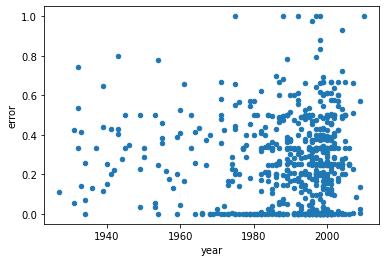

In [48]:
movieyear.plot('year', 'error', kind = 'scatter')

### Lab project 3: Do gender stereotypes in film weaken over time?

It probably doesn't make sense to try to answer this question with a single big model of all movies, because the gender norms involved in shaping dialogue could have *changed* over time.

Instead, let's find the median release date for characters, and divide our dataset into two roughly evenly-sized groups (early and late). Then we can cross-validate models to predict gender in each half of the dataset, and see if the accuracy of the later model is lower.

We can start by doing this just once for each half of the data. Then, to get a sense of uncertainty, we can write a loop that repeatedly resamples the data and runs the cross-validation, say, twenty times for each half of the timeline. We can compare the sets of accuracies to see if the difference of means is significant.

Then we'll consider possible confounding factors that could be producing this result.

In [49]:
# deleted because it overlaps with homework

In [57]:
# deleted because it overlaps with homework

In [58]:
# deleted because it overlaps with homework

In [59]:
# deleted because it overlaps with homework